In [2]:
import numpy as np
import pandas as pd

import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
import time

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [3]:
text = pd.read_csv('wiki_sentences_v2.csv')
text.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [4]:
doc = nlp("confused and frustrated, connie decides to leave on her own.")

for tok in doc:
    print(tok.text, "----->", tok.dep_)

confused -----> advcl
and -----> cc
frustrated -----> conj
, -----> punct
connie -----> nsubj
decides -----> ROOT
to -----> aux
leave -----> xcomp
on -----> prep
her -----> poss
own -----> pobj
. -----> punct


In [8]:
# def get_entities(sent):
#   print(f"Sentance: {sent}\n")
#   time.sleep(1)
#   ent1 = ""
#   ent2 = ""

#   prv_tok_dep = ""    
#   prv_tok_text = ""   

#   prefix = ""
#   modifier = ""

  
  
#   for tok in nlp(sent):
#     print("Entering the loop...\n")
#     print(f"Current word : {tok.text}")
#     print(f"tok.dep_ = {tok.dep_}")
#     if tok.dep_ != "punct":
#       print(f"tok.dep_ is not punctuation")
#       if tok.dep_ == "compound":
#         print("tok.dep_ is not punctuation but is compound")
#         prefix = tok.text
#         print(f"updating prefix to: {tok.text}")
#         if prv_tok_dep == "compound":
#           print("Here tok.dep_ is not punctuation but is compound and previous tok.dep_ is also compound")
#           prefix = prv_tok_text + " "+ tok.text
#           print(f"prefix updated to {prv_tok_text} {tok.text}")
      
     
#       if tok.dep_.endswith("mod") == True:
#         print("tok.dep_ is not punctuation but endswith mod")
#         modifier = tok.text
#         print(f"modifier = {tok.text}")
       
#         if prv_tok_dep == "compound":
#           modifier = prv_tok_text + " "+ tok.text
#           print(f"tok.dep_ is not punctuation and previous tok.dep_ is not compound then modifier = {prv_tok_text} {tok.text}")
      
     
#       if tok.dep_.find("subj") == True:
#         ent1 = modifier +" "+ prefix + " "+ tok.text
#         prefix = ""
#         modifier = ""
#         prv_tok_dep = ""
#         prv_tok_text = ""      
#         print(f"tok.dep_ is not punctuation and tok.dep_ is subject then: ")
#         print(f"ent1 = {ent1} or {modifier} +' '+ {prefix} + ' '+ {tok.text}")
#         print(f"prefix : {prefix}")
#         print(f"modifier : {modifier}")
#         print(f"prv_tok_dep : {prv_tok_dep}")
#         print(f"prv_tok_text : {prv_tok_text}")
     
#       if tok.dep_.find("obj") == True:
#         print(f"tok.dep_ is not punctuation and tok.dep_ is object")
#         ent2 = modifier +" "+ prefix +" "+ tok.text
#         print(f"ent2 = {ent2} or {modifier} +' '+ {prefix} + ' '+ {tok.text}")
      
#       print("Update previous tok.dep_ to current tok.dep_")
#       prv_tok_dep = tok.dep_
#       print("Update previous tok.text to current tok.text")
#       prv_tok_text = tok.text
 
#   return [ent1.strip(), ent2.strip()]

In [6]:
def get_entities(sent):
 
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    
  prv_tok_text = ""   

  prefix = ""
  modifier = ""

  
  
  for tok in nlp(sent):
    
    if tok.dep_ != "punct":
     
      if tok.dep_ == "compound":
        prefix = tok.text
        
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
     
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
       
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
     
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

     
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      
      
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
 

  return [ent1.strip(), ent2.strip()]

In [7]:
get_entities("the album was released digitally on august")

['album', 'digitally  august']

In [8]:
entity_pairs = []

for i in tqdm(text["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:19<00:00, 226.25it/s]


In [9]:
entity_pairs[0:5]

[['connie', 'own'],
 ['later  scream', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['', 'outside cult him']]

In [10]:
def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)

    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': '?'},
               {'DEP': 'agent', 'OP': '?'},
               {'POS': 'ADJ', 'OP': '?'}]
    
    matcher.add("matching_1", [pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]: matches[k][2]]

    return (span.text)

In [11]:
get_relation("the album was released digitally on august")

'released'

In [12]:
relations = [get_relation(i) for i in tqdm(text['sentence'])]

100%|██████████| 4318/4318 [00:19<00:00, 220.53it/s]


In [13]:
relations[:10]

['decides',
 'heard in',
 'paralyzed by',
 'set on',
 'wails with',
 "'s",
 'joined',
 'revealed',
 'revealed as',
 'tried']

In [14]:
source = [i[0] for i in entity_pairs]

target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [15]:
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

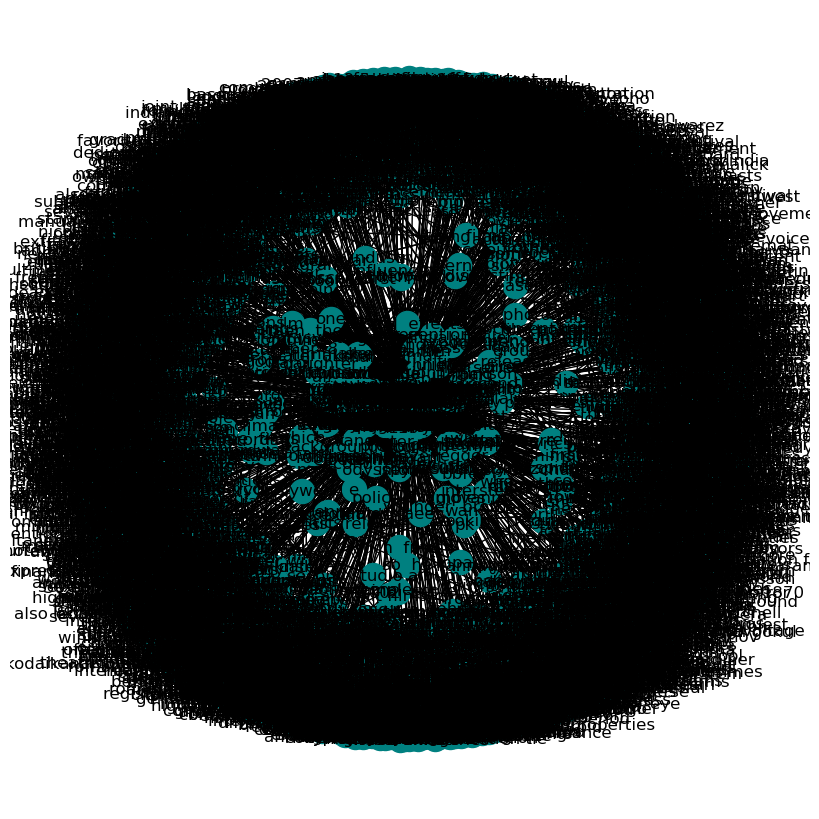

In [16]:
plt.figure(figsize=(8,8))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [17]:
new_df = kg_df[20:50]
new_df.head()

,source,target,edge
20,last which,penn,stand
21,jessica chastain,same character,considered for
22,mauro fiore,cinematographer,served as
23,filming,october,completed on
24,soundtrack,digitally june,released


In [18]:
def create_graph_and_plot(df):
    G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
    plt.figure(figsize=(8,8))

    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos=pos)
    plt.show()

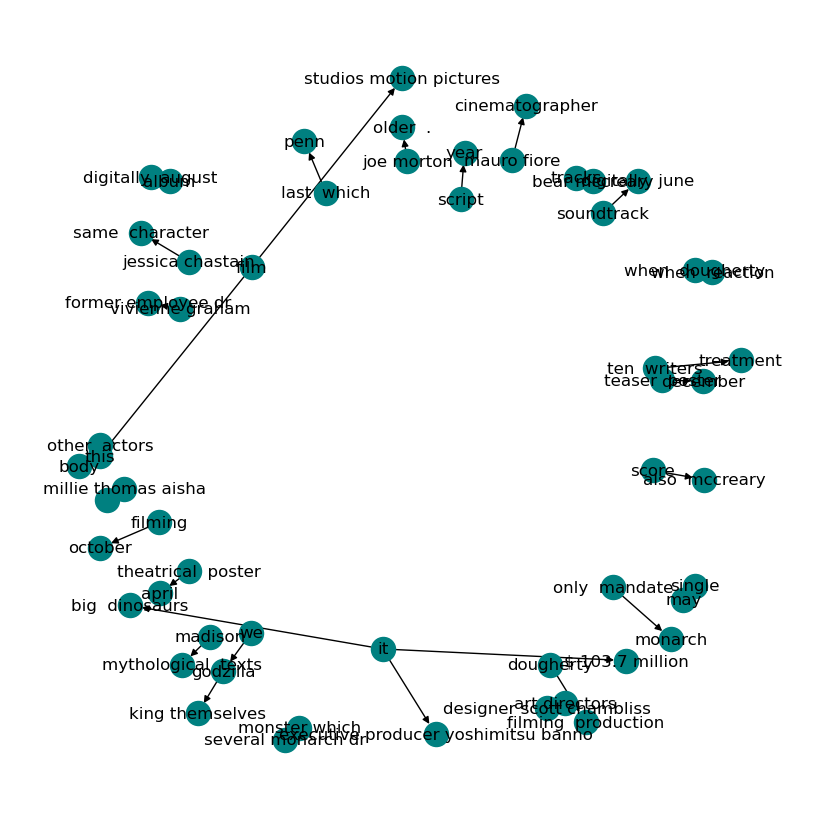

In [19]:
create_graph_and_plot(new_df)